In [2]:
import pandas as pd
from glob import glob
import pybedtools 

In [3]:
peaks_dict = {}
bedtools_dict = {}
for f in glob('6.2_peaks_with_sequences/*cleaned.tsv'):
    print(f)
    
    peaks = pd.read_csv(f, sep='\t')
    print('\t', len(peaks))
    peaks.columns =['label', 'sequence']
    
    peaks['symbol'] = [l.split('|')[1].split(':')[0] for l in peaks.label]
    peaks['enzyme'] = enzyme = f.split('FOX2-')[1].split('_cleaned')[0]
    peaks['chrom'] = [l.split(':')[0] for l in peaks.label]
    peaks['start'] = [l.split(':')[1].split('-')[0] for l in peaks.label]
    peaks['end'] = [l.split(':')[1].split('-')[1].split('(')[0] for l in peaks.label]
    peaks['strand'] = [l.split('(')[1].split(')')[0] for l in peaks.label]

    peaks = peaks[['chrom', 'start', 'end', 'enzyme', 'symbol', 'strand', 'label', 'sequence']]
    peaks_dict[enzyme] = peaks
    
    bedtools_dict[enzyme] = pybedtools.BedTool.from_dataframe(peaks)

6.2_peaks_with_sequences/RBFOX2_ai_FOX2-8e_cleaned.tsv
	 7861
6.2_peaks_with_sequences/RBFOX2_ct_FOX2-APOBEC1_cleaned.tsv
	 1888
6.2_peaks_with_sequences/RBFOX2_both_FOX2-P0078_cleaned.tsv
	 3996
6.2_peaks_with_sequences/RBFOX2_ai_FOX2-MinA_cleaned.tsv
	 735


# Look at gene overlap  by enzyme

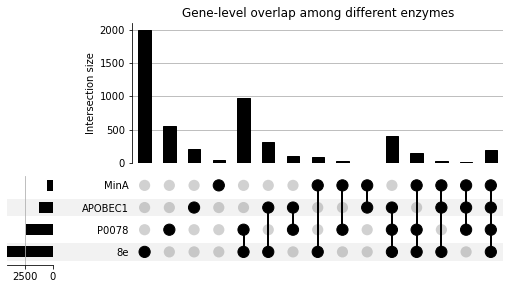

In [3]:
from upsetplot import plot
from upsetplot import generate_counts

from upsetplot import from_contents

contents = {'8e': peaks_dict.get('8e').symbol.unique().tolist(),
             'APOBEC1': peaks_dict.get('APOBEC1').symbol.unique().tolist(),
             'P0078': peaks_dict.get('P0078').symbol.unique().tolist(),
            'MinA': peaks_dict.get('MinA').symbol.unique().tolist()
           }
example = from_contents(contents)

from matplotlib import pyplot as plt
fig = plt.figure(figsize=(12, 8))

plot(example, fig=fig)
plt.title("Gene-level overlap among different enzymes")
plt.savefig('images/svgs/gene_level/gene_level_overlap_across_enzymes.svg', bbox_inches='tight')


In [4]:
peaks_dict.get('8e')

,chrom,start,end,enzyme,symbol,strand,label,sequence
0,1,1216923,1216953,8e,SDF4,-,1:1216923-1216953(-)|SDF4:exon_0,CACATACATTTACTTTAAATATAGTTGCCT
1,1,1319834,1319939,8e,INTS11,-,1:1319834-1319939(-)|INTS11:exon_10,GTGGTTTCTTCTCAGACACGGTGGGGTCCCCAGTGCCTTCCTGGGG...
2,1,1328456,1328486,8e,CPTP,+,1:1328456-1328486(+)|CPTP:exon_6,AGCCCCTGCACGGCACCAGTTCCCCGAGGG
3,1,1391201,1391381,8e,CCNL2,-,1:1391201-1391381(-)|CCNL2:exon_14,CCCTGGAGGAAGAGGAAGAGGAACCCAAGAGGATGGCTTGTCTCCC...
4,1,1401938,1402088,8e,MRPL20,-,1:1401938-1402088(-)|MRPL20:exon_0,CACTGAGGACTGTTGCTGTATTGATTAGGAAAAGAGACAGAGTAAT...
...,...,...,...,...,...,...,...,...
7856,X,154512329,154512419,8e,FAM3A,-,X:154512329-154512419(-)|FAM3A:exon_12,TCTCCCAGGCTGGAGTGCAGTGGTGCAATCTCGGTTCACTGCAACC...
7857,X,154816942,154817062,8e,MPP1,-,X:154816942-154817062(-)|MPP1:intron_25,GAATCCCACCTCATCCCACTTTTTAAGTGT
7858,X,154887789,154887939,8e,F8A1,+,X:154887789-154887939(+)|F8A1:exon_0,TCCTCCGCTGCTTCCACCTAACGCAGCCTCCTGCCTCCGCCTTTGT...
7859,X,155054715,155054985,8e,FUNDC2,+,X:155054715-155054985(+)|FUNDC2:exon_16,GCAGCCTCTACACTCCATCATAGGACATCGAGTCCCTCCTCCTCTT...


# Look at GC and A content for different peaks from different enzymes but on same gene

In [5]:
def has_motif(r):
    return 'GCATG' in r.thickEnd

    
only_with_motif = True  
exclusive_peaks_dict = {}

for this_enzyme in bedtools_dict.keys():
    other_enzymes = list(set(bedtools_dict.keys()).difference({this_enzyme}))
    print(this_enzyme, other_enzymes)

    num_original_peaks = len(bedtools_dict.get(this_enzyme))
    
    exclusive_peaks = bedtools_dict.get(this_enzyme)\
    .intersect(bedtools_dict.get(other_enzymes[0]), v=True)\
    .intersect(bedtools_dict.get(other_enzymes[1]), v=True)\
    .intersect(bedtools_dict.get(other_enzymes[2]), v=True).to_dataframe()
    
    num_exclusive = len(exclusive_peaks)
    
    print(num_original_peaks, num_exclusive)
    
    exclusive_peaks['has_motif'] = exclusive_peaks.apply(has_motif, axis=1)
    
    if only_with_motif:
        exclusive_peaks = exclusive_peaks[exclusive_peaks.has_motif == True]
        
        motif_context = []
        for r in exclusive_peaks.iterrows():
            r = r[1]
            sequence = r.thickEnd
            motif_position = sequence.index('GCATG')
            motif_context.append(sequence[motif_position - 4: motif_position + 9])
        exclusive_peaks['motif_context'] = motif_context
        
        print('\twith motif: {}'.format(len(exclusive_peaks)))

    exclusive_peaks_dict[this_enzyme] = exclusive_peaks
    
    

8e ['MinA', 'APOBEC1', 'P0078']
7861 5975
	with motif: 901
APOBEC1 ['8e', 'MinA', 'P0078']
1888 847
	with motif: 103
P0078 ['8e', 'MinA', 'APOBEC1']
3996 2311
	with motif: 203
MinA ['8e', 'APOBEC1', 'P0078']
735 182
	with motif: 31


In [6]:
exclusive_peaks_dict[this_enzyme]

,chrom,start,end,name,score,strand,thickStart,thickEnd,has_motif,motif_context
5,1,19216099,19216204,MinA,EMC1,-,1:19216099-19216204(-)|EMC1:exon_0,AGAGCAGTGGCACAGTCATAGCTCACTGCAGCCTCGAACACCTGGG...,True,ACAGGCATGAGCT
10,1,109063492,109063732,MinA,TAF13,-,1:109063492-109063732(-)|TAF13:intron_1,TGGTGGCTCACACCTGTAATCCCAGCACTTTGGGAGGCTGAGGCGG...,True,CCAGGCATGGAGG
23,10,73250235,73250355,MinA,DNAJC9,-,"10:73250235-73250355(-)|DNAJC9:exon_20,MRPS16:...",GGAGTGCGGTGGTGCAATCTCAGCTCACTGCAATCTCCACCTCCTG...,True,ACAAGCATGCACC
24,10,73776504,73776549,MinA,FUT11,+,10:73776504-73776549(+)|FUT11:intron_5,AGACCTTGTCTCTAAAAAATAAAAGAATTAGCAGGGCATGGTGGT,True,CAGGGCATGGTGG
36,11,62739716,62739836,MinA,TTC9C,+,11:62739716-62739836(+)|TTC9C:intron_7,GGTTCAAGTGATTCTCGTGTCTGAGCCACCCAAGCAGCTGGGATTA...,True,ACAGGCATGTGCC
38,11,94415908,94416043,MinA,MRE11,-,11:94415908-94416043(-)|MRE11:exon_0,AGGTCAGGAGTTCGAGACCAGCAGGGCCAACATGGCGAAACCCCGA...,True,CCAGGCATGGTGG
40,12,50930694,50930739,MinA,METTL7A,+,12:50930694-50930739(+)|METTL7A:exon_4,TGCCTCAGCCTCCTGAGTAGCTGGTATTACAGGCATGCGTCACCA,True,ACAGGCATGCGTC
47,13,21147317,21147452,MinA,SAP18,+,13:21147317-21147452(+)|SAP18:exon_6,TTCAGGGCGCATGAGACCATATTAAATTCTATTTACTATTTGTTGA...,True,GGGCGCATGAGAC
52,14,54427235,54427340,MinA,CNIH1,-,14:54427235-54427340(-)|CNIH1:exon_0,TCATCTGTCATGTCGATGATTATATATGGATACATTTACAAAAATA...,True,TATTGCATGAATG
53,14,74058110,74058260,MinA,ALDH6A1,-,14:74058110-74058260(-)|ALDH6A1:exon_0,CCACCTCCTGGGTTCAAGTAATTCTCCTGCCTCAGTCTCCCGAGTA...,True,AGGTGCATGCCCC


In [7]:
from collections import defaultdict 

common_genes = defaultdict(lambda:defaultdict(lambda:[]))
common_genes_motif_context = defaultdict(lambda:defaultdict(lambda:[]))

gene_count = defaultdict(lambda:set())

for enzyme in exclusive_peaks_dict.keys():
    for r in exclusive_peaks_dict.get(enzyme).iterrows():
        r = r[1]
        symbol = r.score
        sequence = r.thickEnd
        motif_context = r.motif_context
        common_genes[symbol][enzyme].append(sequence)
        common_genes_motif_context[symbol][enzyme].append(motif_context)
        gene_count[symbol].add(enzyme)

In [8]:
genes_with_multiple_enzymes = []
for g,e in gene_count.items():
    if len(e) > 1:
        print(g, e)
        genes_with_multiple_enzymes.append(g)

AL591806.3 {'8e', 'APOBEC1'}
EXOC8 {'8e', 'P0078'}
MAPK8 {'8e', 'P0078'}
AL355315.1 {'8e', 'P0078'}
APBB1 {'8e', 'P0078'}
TTC9C {'8e', 'MinA'}
RELT {'8e', 'P0078'}
CAND1 {'8e', 'P0078'}
CNIH1 {'8e', 'MinA'}
ARPP19 {'8e', 'P0078'}
PPIB {'8e', 'P0078'}
CSNK2A2 {'8e', 'APOBEC1'}
TXNL4B {'8e', 'P0078'}
RFWD3 {'8e', 'P0078'}
GNA13 {'8e', 'APOBEC1'}
PGS1 {'8e', 'P0078'}
CENPX {'8e', 'P0078'}
VAPA {'8e', 'MinA'}
FUZ {'8e', 'P0078'}
ZNF587B {'8e', 'P0078'}
FAM168B {'8e', 'APOBEC1'}
GPD2 {'8e', 'MinA'}
BZW1 {'8e', 'APOBEC1'}
DNAJB2 {'8e', 'P0078'}
EIF3L {'8e', 'P0078'}
NUP155 {'8e', 'APOBEC1', 'P0078'}
HNRNPH1 {'8e', 'P0078'}
SESN1 {'8e', 'P0078'}
PVT1 {'8e', 'APOBEC1'}
TCEAL1 {'8e', 'APOBEC1'}
GDI1 {'8e', 'P0078'}
DHRS7 {'APOBEC1', 'P0078'}
CCNL1 {'APOBEC1', 'P0078'}
VTA1 {'APOBEC1', 'P0078'}
EMC1 {'MinA', 'P0078'}
ZFAND2A {'MinA', 'P0078'}
TWISTNB {'MinA', 'P0078'}
SPIN1 {'MinA', 'P0078'}


In [9]:
def get_gc_content(p):
    num_c = p.count('C')
    num_g = p.count('G')
    return (num_c + num_g) / len(p)

def get_a_content(p):
    num_a = p.count('A')
    return (num_a) / len(p)
    
    
get_gc_content('ATC')

0.3333333333333333

In [10]:
all_info = []
all_info_motif_context = []

for gene_name in genes_with_multiple_enzymes:
    for enzyme, peak_sequences in common_genes.get(gene_name).items():
        all_seq = ''.join(peak_sequences)
        
        a_content = get_a_content(all_seq)
        gc_content = get_gc_content(all_seq)

        all_info.append([enzyme, gene_name, gc_content, a_content])
        
    for enzyme, motif_context in common_genes_motif_context.get(gene_name).items():
        all_motif_context = ''.join(motif_context)
        if len(all_motif_context) > 0:
            a_content = get_a_content(all_motif_context)
            gc_content = get_gc_content(all_motif_context)

            all_info_motif_context.append([enzyme, gene_name, gc_content, a_content])

In [11]:
all_info_df = pd.DataFrame(all_info, columns=['enzyme', 'symbol', 'GC_content', 'A_content'])
all_info_motif_context_df = pd.DataFrame(all_info_motif_context, columns=['enzyme', 'symbol', 'GC_content', 'A_content'])

In [12]:
content_info_per_enzyme = {}
content_info_per_enzyme_motif_context = {}


for enzyme in all_info_df.enzyme.unique():
    info_for_enzyme = all_info_df[all_info_df.enzyme == enzyme]
    
    content_info_per_enzyme[enzyme] = {'GC': list(info_for_enzyme.GC_content),
                                       'A': list(info_for_enzyme.A_content)
                                      }
    
for enzyme in all_info_motif_context_df.enzyme.unique():
    info_for_enzyme = all_info_motif_context_df[all_info_motif_context_df.enzyme == enzyme]

    content_info_per_enzyme_motif_context[enzyme] = {'GC': list(info_for_enzyme.GC_content),
                                       'A': list(info_for_enzyme.A_content)
                                      }

In [13]:
symbol_info_gc = []
symbol_info_a = []

for symbol in all_info_df.symbol.unique():
    gc_value_8e = all_info_df[(all_info_df.symbol == symbol) & (all_info_df.enzyme == '8e')].GC_content.mean()
    gc_value_p0078 = all_info_df[(all_info_df.symbol == symbol) & (all_info_df.enzyme == 'P0078')].GC_content.mean()
    gc_value_mina = all_info_df[(all_info_df.symbol == symbol) & (all_info_df.enzyme == 'MinA')].GC_content.mean()
    gc_value_apobec = all_info_df[(all_info_df.symbol == symbol) & (all_info_df.enzyme == 'APOBEC1')].GC_content.mean()
    
    a_value_8e = all_info_df[(all_info_df.symbol == symbol) & (all_info_df.enzyme == '8e')].A_content.mean()
    a_value_p0078 = all_info_df[(all_info_df.symbol == symbol) & (all_info_df.enzyme == 'P0078')].A_content.mean()
    a_value_mina = all_info_df[(all_info_df.symbol == symbol) & (all_info_df.enzyme == 'MinA')].A_content.mean()
    a_value_apobec = all_info_df[(all_info_df.symbol == symbol) & (all_info_df.enzyme == 'APOBEC1')].A_content.mean()

    symbol_info_gc.append([symbol, gc_value_8e, gc_value_p0078, gc_value_mina, gc_value_apobec])
    symbol_info_a.append([symbol, a_value_8e, a_value_p0078, a_value_mina, a_value_apobec])

    
symbol_info_gc_motif_context = []
symbol_info_a_motif_context = []

for symbol in all_info_motif_context_df.symbol.unique():
    gc_value_8e = all_info_motif_context_df[(all_info_motif_context_df.symbol == symbol) & (all_info_motif_context_df.enzyme == '8e')].GC_content.mean()
    gc_value_p0078 = all_info_motif_context_df[(all_info_motif_context_df.symbol == symbol) & (all_info_motif_context_df.enzyme == 'P0078')].GC_content.mean()
    gc_value_mina = all_info_motif_context_df[(all_info_motif_context_df.symbol == symbol) & (all_info_motif_context_df.enzyme == 'MinA')].GC_content.mean()
    gc_value_apobec = all_info_motif_context_df[(all_info_motif_context_df.symbol == symbol) & (all_info_motif_context_df.enzyme == 'APOBEC1')].GC_content.mean()
    
    a_value_8e = all_info_motif_context_df[(all_info_motif_context_df.symbol == symbol) & (all_info_motif_context_df.enzyme == '8e')].A_content.mean()
    a_value_p0078 = all_info_motif_context_df[(all_info_motif_context_df.symbol == symbol) & (all_info_motif_context_df.enzyme == 'P0078')].A_content.mean()
    a_value_mina = all_info_motif_context_df[(all_info_motif_context_df.symbol == symbol) & (all_info_motif_context_df.enzyme == 'MinA')].A_content.mean()
    a_value_apobec = all_info_motif_context_df[(all_info_motif_context_df.symbol == symbol) & (all_info_motif_context_df.enzyme == 'APOBEC1')].A_content.mean()

    symbol_info_gc_motif_context.append([symbol, gc_value_8e, gc_value_p0078, gc_value_mina, gc_value_apobec])
    symbol_info_a_motif_context.append([symbol, a_value_8e, a_value_p0078, a_value_mina, a_value_apobec])


In [14]:
per_gene_info_gc_df = pd.DataFrame(symbol_info_gc, columns=['symbol', '8e', 'p0078', 'MinA', 'APOBEC1'])
per_gene_info_a_df = pd.DataFrame(symbol_info_a, columns=['symbol', '8e', 'p0078', 'MinA', 'APOBEC1'])

per_gene_info_gc_motif_context_df = pd.DataFrame(symbol_info_gc_motif_context, columns=['symbol', '8e', 'p0078', 'MinA', 'APOBEC1'])
per_gene_info_a_motif_context_df = pd.DataFrame(symbol_info_a_motif_context, columns=['symbol', '8e', 'p0078', 'MinA', 'APOBEC1'])

In [15]:
per_gene_info_gc_df.index = per_gene_info_gc_df['symbol']
per_gene_info_a_df.index = per_gene_info_a_df['symbol']

per_gene_info_gc_motif_context_df.index = per_gene_info_gc_motif_context_df['symbol']
per_gene_info_a_motif_context_df.index = per_gene_info_a_motif_context_df['symbol']

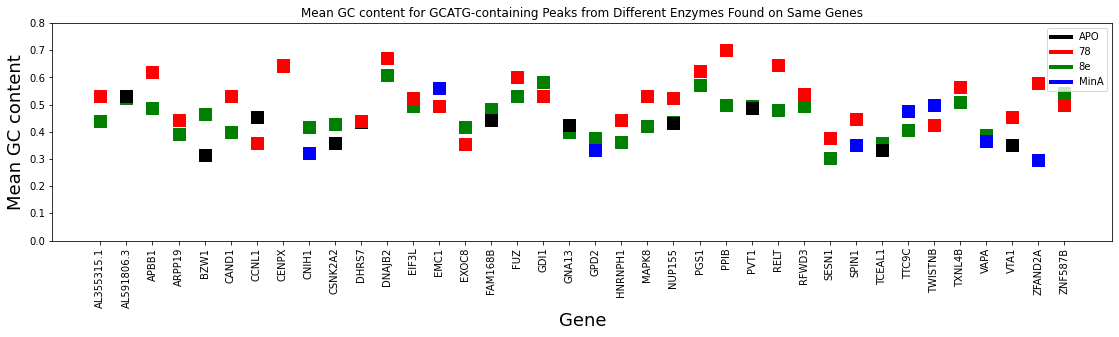

In [29]:
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D

color_map = {
    'APO': 'black',
    '78': 'red',
    '8e': 'green',
    'MinA': 'blue'
}

custom_lines = []
legend = []
for enzyme, color in color_map.items():
    custom_lines.append(Line2D([0], [0], color=color, lw=4))
    legend.append(enzyme)

size = 150

plt.figure(figsize=(19, 4))
plt.scatter(per_gene_info_gc_df.sort_index().index, per_gene_info_gc_df.sort_index()[['8e']], color='g', marker='s', s=size)
#plt.axhline(float(per_gene_info_gc_df[['8e']].mean()), color='g', linestyle='--')
plt.scatter(per_gene_info_gc_df.sort_index().index, per_gene_info_gc_df.sort_index()[['APOBEC1']], color='k', marker='s', s=size)
#plt.axhline(float(per_gene_info_gc_df[['APOBEC1']].mean()), color='k', linestyle='--')
plt.scatter(per_gene_info_gc_df.sort_index().index, per_gene_info_gc_df.sort_index()[['p0078']], color='r', marker='s', s=size)
#plt.axhline(float(per_gene_info_gc_df[['p0078']].mean()), color='r', linestyle='--')
plt.scatter(per_gene_info_gc_df.sort_index().index, per_gene_info_gc_df.sort_index()[['MinA']], color='b', marker='s', s=size)
#plt.axhline(float(per_gene_info_gc_df[['MinA']].mean()), color='b', linestyle='--')

plt.legend(custom_lines, legend)
plt.ylabel('Mean GC content', fontsize=18)
plt.xlabel('Gene', fontsize=18)
# We change the fontsize of minor ticks label 
plt.tick_params(axis='x', which='major', labelsize=10, rotation=90)

motif_text = ''
if only_with_motif:
    motif_text = 'GCATG-containing '
plt.ylim(0, .8)

plt.title("Mean GC content for {}Peaks from Different Enzymes Found on Same Genes".format(motif_text))
plt.savefig('images/svgs/gene_level/mean_gc_content_for_different_enzyme_peaks_on_same_gene.svg', bbox_inches='tight')


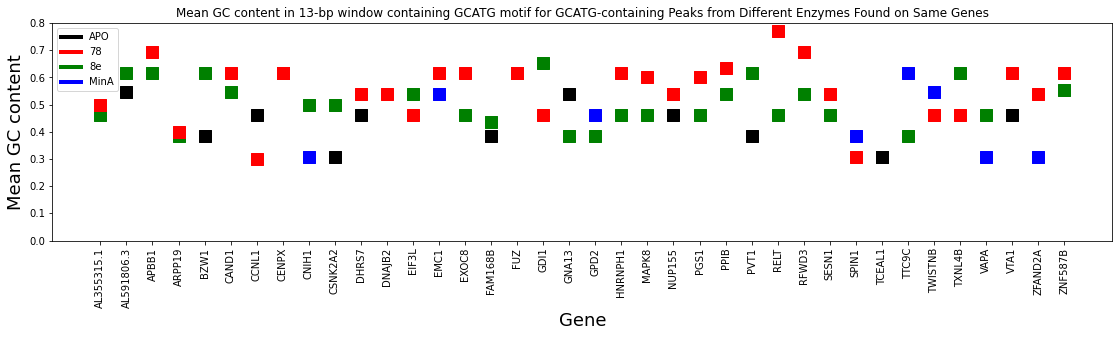

In [30]:
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D

color_map = {
    'APO': 'black',
    '78': 'red',
    '8e': 'green',
    'MinA': 'blue'
}

custom_lines = []
legend = []
for enzyme, color in color_map.items():
    custom_lines.append(Line2D([0], [0], color=color, lw=4))
    legend.append(enzyme)

size = 150

plt.figure(figsize=(19, 4))
plt.scatter(per_gene_info_gc_motif_context_df.sort_index().index, per_gene_info_gc_motif_context_df.sort_index()[['8e']], color='g', marker='s', s=size)
#plt.axhline(float(per_gene_info_gc_df[['8e']].mean()), color='g', linestyle='--')
plt.scatter(per_gene_info_gc_motif_context_df.sort_index().index, per_gene_info_gc_motif_context_df.sort_index()[['APOBEC1']], color='k', marker='s', s=size)
#plt.axhline(float(per_gene_info_gc_df[['APOBEC1']].mean()), color='k', linestyle='--')
plt.scatter(per_gene_info_gc_motif_context_df.sort_index().index, per_gene_info_gc_motif_context_df.sort_index()[['p0078']], color='r', marker='s', s=size)
#plt.axhline(float(per_gene_info_gc_df[['p0078']].mean()), color='r', linestyle='--')
plt.scatter(per_gene_info_gc_motif_context_df.sort_index().index, per_gene_info_gc_motif_context_df.sort_index()[['MinA']], color='b', marker='s', s=size)
#plt.axhline(float(per_gene_info_gc_df[['MinA']].mean()), color='b', linestyle='--')

plt.legend(custom_lines, legend)
plt.ylabel('Mean GC content', fontsize=18)
plt.xlabel('Gene', fontsize=18)
# We change the fontsize of minor ticks label 
plt.tick_params(axis='x', which='major', labelsize=10, rotation=90)

motif_text = ''
if only_with_motif:
    motif_text = 'GCATG-containing '
plt.ylim(0, .8)

plt.title("Mean GC content in 13-bp window containing GCATG motif for {}Peaks from Different Enzymes Found on Same Genes".format(motif_text))
plt.savefig('images/svgs/gene_level/mean_gc_content_for_different_enzyme_gcatg_context_on_same_gene.svg', bbox_inches='tight')


In [31]:
df = exclusive_peaks_dict.get('8e')
df[df.score == 'SLC39A1']

,chrom,start,end,name,score,strand,thickStart,thickEnd,has_motif,motif_context


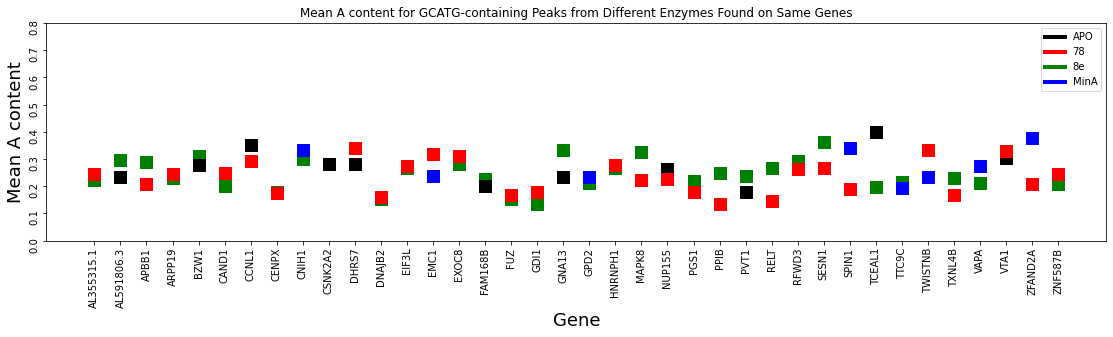

In [35]:
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D

color_map = {
    'APO': 'black',
    '78': 'red',
    '8e': 'green',
    'MinA': 'blue'
}

custom_lines = []
legend = []
for enzyme, color in color_map.items():
    custom_lines.append(Line2D([0], [0], color=color, lw=4))
    legend.append(enzyme)

size = 150

plt.figure(figsize=(19, 4))
plt.scatter(per_gene_info_a_df.sort_index().index, per_gene_info_a_df.sort_index()[['8e']], color='g', marker='s', s=size)
#plt.axhline(float(per_gene_info_a_df[['8e']].mean()), color='g', linestyle='--')
plt.scatter(per_gene_info_a_df.sort_index().index, per_gene_info_a_df.sort_index()[['APOBEC1']], color='k', marker='s', s=size)
#plt.axhline(float(per_gene_info_a_df[['APOBEC1']].mean()), color='k', linestyle='--')
plt.scatter(per_gene_info_a_df.sort_index().index, per_gene_info_a_df.sort_index()[['p0078']], color='r', marker='s', s=size)
#plt.axhline(float(per_gene_info_a_df[['p0078']].mean()), color='r', linestyle='--')
plt.scatter(per_gene_info_a_df.sort_index().index, per_gene_info_a_df.sort_index()[['MinA']], color='b', marker='s', s=size)
#plt.axhline(float(per_gene_info_a_df[['MinA']].mean()), color='b', linestyle='--')

plt.legend(custom_lines, legend)
plt.ylabel('Mean A content', fontsize=18)
plt.xlabel('Gene', fontsize=18)
# We change the fontsize of minor ticks label 
plt.tick_params(axis='both', which='major', labelsize=10, rotation=90)
plt.ylim(0, 0.8)

motif_text = ''
if only_with_motif:
    motif_text = 'GCATG-containing '
    
plt.title("Mean A content for {}Peaks from Different Enzymes Found on Same Genes".format(motif_text))
plt.savefig('images/svgs/gene_level/mean_a_content_for_different_enzyme_peaks_on_same_gene.svg', bbox_inches='tight')


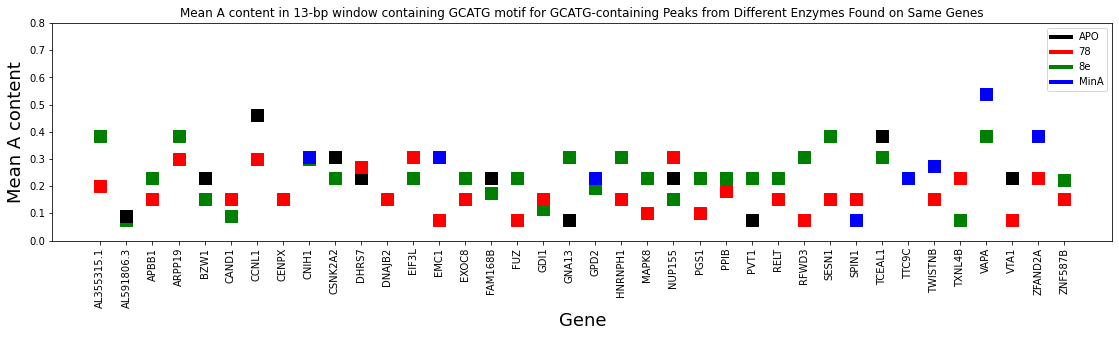

In [36]:
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D

color_map = {
    'APO': 'black',
    '78': 'red',
    '8e': 'green',
    'MinA': 'blue'
}

custom_lines = []
legend = []
for enzyme, color in color_map.items():
    custom_lines.append(Line2D([0], [0], color=color, lw=4))
    legend.append(enzyme)

size = 150

plt.figure(figsize=(19, 4))
plt.scatter(per_gene_info_a_motif_context_df.sort_index().index, per_gene_info_a_motif_context_df.sort_index()[['8e']], color='g', marker='s', s=size)
#plt.axhline(float(per_gene_info_gc_df[['8e']].mean()), color='g', linestyle='--')
plt.scatter(per_gene_info_a_motif_context_df.sort_index().index, per_gene_info_a_motif_context_df.sort_index()[['APOBEC1']], color='k', marker='s', s=size)
#plt.axhline(float(per_gene_info_gc_df[['APOBEC1']].mean()), color='k', linestyle='--')
plt.scatter(per_gene_info_a_motif_context_df.sort_index().index, per_gene_info_a_motif_context_df.sort_index()[['p0078']], color='r', marker='s', s=size)
#plt.axhline(float(per_gene_info_gc_df[['p0078']].mean()), color='r', linestyle='--')
plt.scatter(per_gene_info_a_motif_context_df.sort_index().index, per_gene_info_a_motif_context_df.sort_index()[['MinA']], color='b', marker='s', s=size)
#plt.axhline(float(per_gene_info_gc_df[['MinA']].mean()), color='b', linestyle='--')

plt.legend(custom_lines, legend)
plt.ylabel('Mean A content', fontsize=18)
plt.xlabel('Gene', fontsize=18)
# We change the fontsize of minor ticks label 
plt.tick_params(axis='x', which='major', labelsize=10, rotation=90)
plt.ylim(0, 0.8)

motif_text = ''
if only_with_motif:
    motif_text = 'GCATG-containing '
    
plt.title("Mean A content in 13-bp window containing GCATG motif for {}Peaks from Different Enzymes Found on Same Genes".format(motif_text))
plt.savefig('images/svgs/gene_level/mean_a_content_for_different_enzyme_gcatg_context_on_same_gene.svg', bbox_inches='tight')
